# Import

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy import integrate
from classy import Class

import eboss_qso.measurements as eboss

In [2]:
from matplotlib.pyplot import rc
import matplotlib.font_manager
rc('font',**{'size':'22','family':'serif','serif':['CMU serif']})
rc('mathtext', **{'fontset':'cm'})
rc('text', usetex=True)
rc('legend',**{'fontsize':'18'})
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['legend.fontsize'] = 15
#matplotlib.rcParams['legend.title_fontsize'] = 25
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.minor.size'] = 2.5
matplotlib.rcParams['ytick.minor.size'] = 2.5
matplotlib.rcParams['xtick.major.width'] = 1.5
matplotlib.rcParams['ytick.major.width'] = 1.5
matplotlib.rcParams['xtick.minor.width'] = 1.5
matplotlib.rcParams['ytick.minor.width'] = 1.5
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Cosmology and $P(k)$

In [3]:
h = 0.6766
z_pk = np.linspace(0.8, 2.2, 100) # redshit a cui calcolarlo
Omega_cdm = 0.26069
Omega_b = 0.04897

k = 10**(np.linspace(-3, 0, 100))#np.loadtxt("fits/input/models/k_eff_old.dat") #h/Mpc

class_params = {
            "output": "dTk mPk", 
            #"extra metric transfer functions": 'yes', 
            "n_s": 0.9652, 
            "gauge": "synchronous", 
            "N_ur": 2.0328, 
            "h": 0.6766, 
            "ln10^{10}A_s": 3.043, 
            "k_pivot": 0.05, 
            "tau_reio": 0.054, 
            "T_cmb": 2.7255, 
            "Omega_cdm": 0.26069, 
            "Omega_b": 0.04897, 
            "Omega_k": 0.0, 
            "N_ncdm": 1, 
            "m_ncdm": 0.06, 
            "P_k_max_h/Mpc": 10.0, 
            "z_max_pk": 100.0
        }


c = Class()
c.set(class_params)
c.compute()

#print(kp)

In [4]:
pk_z = []

for z in z_pk:
    # power spectrum in (Mpc/h)^3, k è h/Mpc
    pk = np.array([c.pk(x, z) for x in k * h]) * h**3.
    pk_z.append(pk)
    
pk_z = np.array(pk_z)
print(pk_z.shape)

pk = np.array([c.pk(x, 0) for x in k * h]) * h**3.

(100, 100)


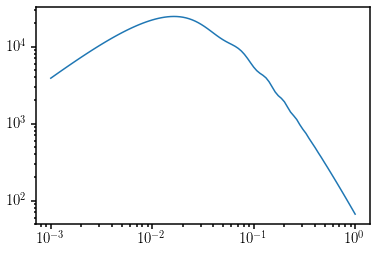

In [5]:
plt.loglog(k, pk)

In [6]:
import scipy
import scipy.special
import scipy.integrate

def D_hypergeom(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if bg.__contains__('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        
    x = Ol/Om*avec**3
    D = avec*scipy.special.hyp2f1(1./3.,1,11./6.,-x)
    D_today = scipy.special.hyp2f1(1./3.,1,11./6.,-Ol/Om)
    return D/D_today

def f_hypergeom(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if bg.__contains__('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        
    x = Ol/Om*avec**3
    D = avec*scipy.special.hyp2f1(1./3.,1,11./6.,-x)
    f = 1.-6./11.*x*avec/D*scipy.special.hyp2f1(4./3.,2,17./6.,-x)
    return f

def D_integral2(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if bg.__contains__('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
        w0 = -1
        wa = 0.0
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        w0 = csm.pars['w0_fld']
        wa = csm.pars['wa_fld']
    D = np.zeros(avec.shape)
    for idx, a in enumerate(avec):
        Hc = a*np.sqrt(Om/a**3 + Ol*a**(-3*(1+w0+wa))*np.exp(-3.*(1.0-a)*wa) )
        Dintegrand2 = lambda a: (a*np.sqrt(Om/a**3 + Ol*a**(-3*(1+w0+wa))*np.exp(-3.*(1.0-a)*wa) ))**(-3)
        I = scipy.integrate.quad(Dintegrand2, 1e-15,a)
        D[idx] = Hc/a*I[0]
    D = D/scipy.integrate.quad(Dintegrand2,1e-15,1)[0]
    return D

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


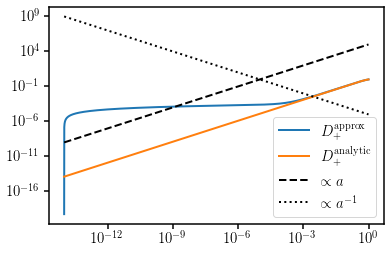

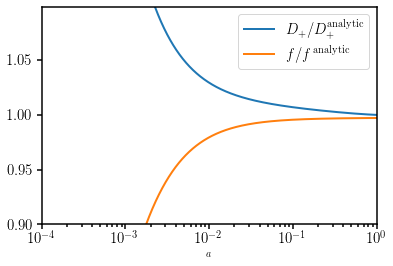

In [7]:
lw=2
aminexp = -4
amin = 10**aminexp
ymin = 10**(aminexp-1)
ymax = 10**(-aminexp+1)

bg = c.get_background()

a = 1./(bg['z']+1)
H = bg['H [1/Mpc]']
D = bg['gr.fac. D']
f = bg['gr.fac. f']

plt.loglog(a,D,lw=lw,label=r'$D_+^\mathrm{approx}$')
plt.loglog(a,D_hypergeom(a,c),lw=lw,label=r'$D_+^\mathrm{analytic}$')
#plt.loglog(a,D_integral2(a,c),lw=lw,label=r'$D_+^\mathrm{integral}$')

plt.loglog(a,a*ymax,'k--',lw=lw,label=r'$\propto a$')
plt.loglog(a,1./a*ymin,'k:',lw=lw,label=r'$\propto a^{-1}$')

plt.legend()
plt.show()

plt.semilogx(a,D/D_hypergeom(a,c),lw=lw,label=r'$D_+/D_+^\mathrm{analytic}$')
#ax2.semilogx(a,grow/grow[-1]/D_integral(a,cosmo['CDM']),'--',lw=5)
plt.semilogx(a,f/f_hypergeom(a,c),lw=lw,label=r'$f/f^{\,\mathrm{analytic}}$')

plt.xlim([10**aminexp,1]) 
plt.xlabel(r'$a$',fontsize=10)
plt.ylim([ymin,ymax])
plt.ylim([0.9,1.099])
plt.legend()

In [10]:
doz = interpolate.interp1d(bg['z'], bg['comov. dist.'])
Hoz = interpolate.interp1d(bg['z'], bg['H [1/Mpc]'])

# $P_{0, \, eff}(k)$

$$ P_0(k,z) = \left( b^2(z) + \frac{2}{3} \, b(z) \, f(z) + \frac{1}{5} \, f^2(z) \right) \,  P_m(k, z=0) \, D_+^2(z) \, ,$$
where $D_+(0)=1$ and 
$$ b(z) = b_1(z) + f_{\rm NL} \, (b_1(z) - p) \, \frac{3 \, \Omega_m \, H_0^2 \, \delta_c}{c^2 \, k^2 \, T(k) \, D(z)} \, ,$$
with $T(0)=1$ and $D(z)$ normalized to $(1+z)^{-1}$ in the matter era.
The monoole of the power spectrum can be computed at the effective redshift $P_0(k) = P_0(k,z=z_{\rm eff})$ (**P0_zeff_fnl0** and **P0_zeff_fnl**) or we can compute the effective power spectrum integrating over the redshift dependence.
$$ P_{0, \, eff}(k) = \frac{P_m(k,z=0)}{N} \, A_{k^0} + 2 \, f_{\rm NL} \, \frac{P_m(k,z=0)}{N} \, \frac{C}{T(k) \, k^2} \, A_{k^2} + \frac{P_m(k,z=0)}{N} \, \frac{f_{\rm NL}^2 \, C^2}{T^2(k) \, k^4} \, A_{k^4} \, .$$
In this equation $C = \frac{3 \, \Omega_m \, H_0^2 \, \delta_c}{c^2}$, and note that in the code c.Hubble(0)$=H_0/c^2$, then
$$ N = \int {\rm d}z \, n^2(z) \, \left(\frac{\chi(z)^2}{H(z)} \right) \, w_{\rm FKP}^2(z) \, w_{\rm c}^2 \, w(z) \, = \sum_{i=1}^{N_g} n(z) \,  w_{\rm FKP}^2(z) \, w_{\rm c}^2 \, w(z) \, .$$
Here $w(z)$ is either $w(z) = w_0(z) \, \tilde{w}(z)$ (our weights) or $w(z) = |w_0(z) \, \tilde{w}(z)|$, Mueller's weights. This is implemented (witout the summation) in **get_weights**. The coefficients for the different $k$ dependent contribution to the power spectrum monopole are,
$$ A_{k^0} = \int {\rm d}z \, n^2(z) \, \left(\frac{\chi(z)^2}{H(z)} \right) \, w_{\rm FKP}^2(z) \, w_{\rm c}^2 \, w(z) \, D_+^2(z) \, \left(b_1^2(z) + \frac{2}{3} \, f(z) \, b_1(z) + \frac{1}{5} \, f^2(z)\right) \\ = \sum_{i=1}^{N_g} n(z) \,  w_{\rm FKP}^2(z) \, w_{\rm c}^2 \, w(z) \, D_+^2(z) \, \left(b_1^2(z) + \frac{2}{3} \, f(z) \, b_1(z) + \frac{1}{5} \, f^2(z)\right) \, ,$$
implemented (witout the summation) in **get_redshift_dependence_fnl0**,
$$ A_{k^2} = \int {\rm d}z \, n^2(z) \, \left(\frac{\chi(z)^2}{H(z)} \right) \, w_{\rm FKP}^2(z) \, w_{\rm c}^2 \, w(z) \, D_+^2(z) \, \frac{(b_1(z) - p) \, \left( b_1(z) + \frac{1}{3} f(z) \right)}{D(z)} \\ = \sum_{i=1}^{N_g} n(z) \,  w_{\rm FKP}^2(z) \, w_{\rm c}^2 \, w(z) \, D_+^2(z) \, \frac{(b_1(z) - p) \, \left( b_1(z) + \frac{1}{3} f(z) \right)}{D(z)} \, ,$$
implemented (witout the summation) in **get_redshift_dependence_k2**, and
$$ A_{k^4} = \int {\rm d}z \, n^2(z) \, \left(\frac{\chi(z)^2}{H(z)} \right) \, w_{\rm FKP}^2(z) \, w_{\rm c}^2 \, w(z) \, D_+^2(z) \, \frac{(b_1(z) - p)^2}{D^2(z)} \\ = \sum_{i=1}^{N_g} n(z) \,  w_{\rm FKP}^2(z) \, w_{\rm c}^2 \, w(z) \, D_+^2(z) \, \frac{(b_1(z) - p)^2}{D^2(z)} \, ,$$
implemented (witout the summation) in **get_redshift_dependence_k4**.

In [11]:
data_N = eboss.read_data('N', 'dr16')
data_S = eboss.read_data('S', 'dr16')

eboss.finalize_data(data_N, eboss.fidcosmo, 'dr16', P0_FKP=3e4)
eboss.finalize_data(data_S, eboss.fidcosmo, 'dr16', P0_FKP=3e4)

In [12]:
def get_weights(r, p=None, P0=3e4, eva=False):
    """
    """
    assert 'Z' in r.columns
    assert 'NZ' in r.columns

    C = 299792.458
    # weights
    w_fkp = 1. / (1 + r['NZ']*P0)
    w_comp = r['Weight']
    if p is not None:
        w1 = eboss.weights.fnl_weight(r['Z'], p=p)
        w2 = eboss.weights.bias_weight(r['Z'], eboss.fidcosmo, ell=0)
    else:
        w1 = w2 = 1.0

    #chi2 = r['Z'].map_blocks(doz)**2
    #Hz = r['Z'].map_blocks(Hoz)
    
    w = np.abs(w1 * w2) if eva else w1 * w2
    #As I compute the integral via MonteCarlo I lose a power of n(z) and the dchi differential chi^2/H(z)
    A = r['NZ'] * w_fkp**2 * w * w_comp**2

    return A

def get_redshift_dependence_fnl0(z):
    b = eboss.weights.bias_model(z)
    #D2 = z.map_blocks(eboss.fidcosmo.scale_independent_growth_factor)**2
    #f = z.map_blocks(eboss.fidcosmo.scale_independent_growth_rate)
    
    def get_a(x): return 1. / (x + 1.)
    def D(x): return D_hypergeom(x,c)
    def F(x): return f_hypergeom(x,c)
    
    a = z.map_blocks(get_a)
    D2 = a.map_blocks(D)**2
    f = a.map_blocks(F)
    
    A = (b**2 + 2. / 3. * b * f + 1. / 5. * f**2) * D2
    
    return A

def P0_zeff_fnl0(zeff):
    b = eboss.weights.bias_model(zeff)
    #D2 = eboss.fidcosmo.scale_independent_growth_factor(zeff)**2
    #f = eboss.fidcosmo.scale_independent_growth_rate(zeff)
    
    aeff = 1. / (zeff + 1.)
    D2 = D_hypergeom(aeff,c)**2
    f = f_hypergeom(aeff,c)
    
    
    P0 = (b**2 + 2. / 3. * b * f + 1. / 5. * f**2) * D2
    
    return P0

In [13]:
sort = np.argsort(data_N['Z'].compute())
z = data_N['Z'].compute()[sort]

norm_int = get_weights(data_N, p=1.6, eva=True).compute()
norm = np.sum(norm_int[sort])

up_int = get_redshift_dependence_fnl0(data_N['Z']).compute() * norm_int
up = np.sum(up_int[sort])

P0eff = up / norm
print(up)

3.5303425507724526


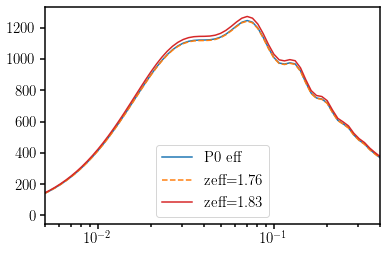

In [14]:
us = P0_zeff_fnl0(1.76)
eva = P0_zeff_fnl0(1.83)

plt.semilogx(k, k * pk * P0eff, label='P0 eff')
plt.semilogx(k, k * pk * us, label='zeff=1.76', linestyle='dashed')
plt.semilogx(k, k * pk * eva, label='zeff=1.83', color='tab:red')

plt.xlim(5e-3,4e-1)
#plt.ylim(2e4,5e4)

plt.legend()

plt.show()

In [17]:
tk = c.get_transfer(0)
tkm = Omega_cdm / (Omega_cdm + Omega_b) * tk['d_cdm'] + Omega_b / (Omega_cdm + Omega_b) * tk['d_b']
tkn = -tkm/tk['k (h/Mpc)']**2
tkn /= tkn[0]
f = interpolate.interp1d(tk['k (h/Mpc)'], tkn)
Tk = f(k)

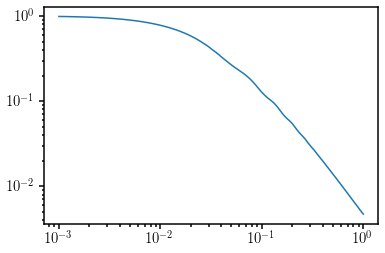

In [18]:
plt.loglog(k, Tk)

In [21]:
Dz = D_hypergeom(a,c)/np.max(D_hypergeom(a,c)*(1+bg['z']))
Doz = interpolate.interp1d(bg['z'], Dz)

def get_redshift_dependence_k2(z,p=1.0):
    b = eboss.weights.bias_model(z)
    #D = z.map_blocks(eboss.fidcosmo.scale_independent_growth_factor)
    #f = z.map_blocks(eboss.fidcosmo.scale_independent_growth_rate)
    #Tok = Tksoz[k_index]
    #T = z.map_blocks(Tok)
    
    def get_a(x): return 1. / (x + 1.)
    def D(x): return D_hypergeom(x,c)
    def F(x): return f_hypergeom(x,c)
    
    a = z.map_blocks(get_a)
    D2 = a.map_blocks(D)**2
    f = a.map_blocks(F)
    D_fnl = z.map_blocks(Doz)
    
    A = (b - p) * (b + 1. / 3. * f) * D2 / D_fnl #/ T
    
    return A

def get_redshift_dependence_k4(z,p=1.0):
    b = eboss.weights.bias_model(z)
    #Tok = Tksoz[k_index]
    #T = z.map_blocks(Tok)
    def get_a(x): return 1. / (x + 1.)
    def D(x): return D_hypergeom(x,c)
    
    a = z.map_blocks(get_a)
    D2 = a.map_blocks(D)**2
    D_fnl = z.map_blocks(Doz)
    
    A = (b - p)**2 * D2 / D_fnl**2 #/ T**2
    
    return A

def P0_zeff_fnl(zeff, ks, p, fnl, curly_C):
    b1 = eboss.weights.bias_model(zeff)
    #D = eboss.fidcosmo.scale_independent_growth_factor(zeff)
    #f = eboss.fidcosmo.scale_independent_growth_rate(zeff)
    
    aeff = 1. / (zeff + 1.)
    D2 = D_hypergeom(aeff,c)**2
    f = f_hypergeom(aeff,c)
    D = Doz(zeff)
    
    k0 = (b1**2. + 2./3. * b1 * f + 1./5. * f**2.) * D2
    k2 = 2. * (b1 - p) * (b1 + 1./3. * f) / D * D2
    k4 = (b1 - p)**2 / D**2 * D2
    
    P = k0 + k2 * fnl * curly_C  / Tk / ks**2 + k4 * fnl**2 * curly_C**2 / Tk**2 / k**4
    
    return P #np.array(P0)

In [22]:
#contrbutions for f_NL=0

norm_int = get_weights(data_N, p=1.6, eva=True).compute()
norm = np.sum(norm_int)

up_int = get_redshift_dependence_fnl0(data_N['Z']).compute() * norm_int
up = np.sum(up_int)

print("k^0 contribution", up / norm)

P0eff_eva = up / norm

norm_int = get_weights(data_N, p=1.6, eva=False).compute()
norm = np.sum(norm_int)

up_int = get_redshift_dependence_fnl0(data_N['Z']).compute() * norm_int
up = np.sum(up_int)

P0eff_us = up / norm

k^0 contribution 1.868972579212427


In [24]:
p = 1.6
fnl_neg = -30
curly_C = 3. * (Omega_cdm + Omega_b) * 100**2 * 1.686 / 299792.458**2
print(curly_C)

# \int dz n^2 (chi^2/H(z)) wfkp^2 wc^2 wo tildew
norm_int_eva = get_weights(data_N, p=1.6, eva=True).compute()
norm_eva = np.sum(norm_int_eva)

norm_int_us = get_weights(data_N, p=1.6, eva=False).compute()
norm_us = np.sum(norm_int_us)

#k dependent contributions
k2_int = get_redshift_dependence_k2(data_N['Z'], p).compute()
k4_int = get_redshift_dependence_k4(data_N['Z'], p).compute()

k2_int_eva = k2_int * norm_int_eva
k4_int_eva = k4_int * norm_int_eva
k2_int_us = k2_int * norm_int_us
k4_int_us = k4_int * norm_int_us

k2_eva = np.sum(k2_int_eva)
k4_eva = np.sum(k4_int_eva)
k2_us =  np.sum(k2_int_us)
k4_us =  np.sum(k4_int_us)

print("k^2 contribution:", k2_eva * 2. / norm_eva)
print("k^4 contribution:", k4_eva / norm_eva)

k2_final_eva = 2. * curly_C * fnl_neg / k**2 * k2_eva / Tk
k4_final_eva = curly_C**2 * fnl_neg**2 / k**4 * k4_eva / Tk**2

P0eff_fnl_eva_30 = P0eff_eva + k2_final_eva / norm_eva + k4_final_eva / norm_eva


k2_final_us = 2. * curly_C * fnl_neg / k**2 * k2_us / Tk
k4_final_us = curly_C**2 * fnl_neg**2 / k**4 * k4_us / Tk**2

P0eff_fnl_us_30 = P0eff_us + k2_final_us / norm_us + k4_final_us / norm_us


1.7426995883365564e-07
k^2 contribution: 3.860136323000499
k^4 contribution: 2.2408607192311485


In [29]:
fnl_pos = 10

k2_final_eva = 2. * curly_C * fnl_pos / k**2 * k2_eva / Tk
k4_final_eva = curly_C**2 * fnl_pos**2 / k**4 * k4_eva / Tk**2

P0eff_fnl_eva10 = P0eff_eva + k2_final_eva / norm_eva + k4_final_eva / norm_eva


k2_final_us = 2. * curly_C * fnl_pos / k**2 * k2_us / Tk
k4_final_us = curly_C**2 * fnl_pos**2 / k**4 * k4_us / Tk**2

P0eff_fnl_us10 = P0eff_us + k2_final_us / norm_us + k4_final_us / norm_us

zeff=1.74456, p=1.6
k^0 contribution: 1.8533898845077674
k^2 contribution: 3.664535697570581
k^4 contribution: 1.8276395679010653
D^2: 0.2072239830542596
D_norm: 0.3575999057132111
f: 0.9459357932563979
b1: 2.6619954670207995
zeff=1.79527, p=1.6
k^0 contribution: 1.885693981776364
k^2 contribution: 3.968975877010917
k^4 contribution: 2.1063419473599527
D^2: 0.20015947791702793
D_norm: 0.35145016483183295
f: 0.9486215746851266
b1: 2.7400925556661995


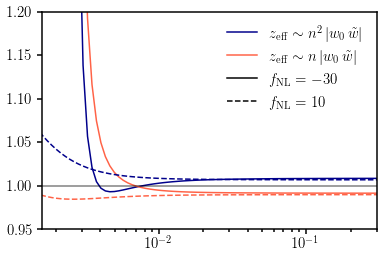

In [30]:
evan2_30 = P0_zeff_fnl(1.74456, k, p, fnl_neg, curly_C)
evan210 = P0_zeff_fnl(1.75, k, p, fnl_pos, curly_C) 

evan_30 = P0_zeff_fnl(1.79527, k, p, fnl_neg, curly_C)
evan10 = P0_zeff_fnl(1.80, k, p, fnl_pos, curly_C)

##fnl=-30
plt.semilogx(k, P0eff_fnl_eva_30 / evan2_30, label='$z_{\\rm eff} \sim n^2 \, |w_0 \, \\tilde{w}|$', color='darkblue')
plt.semilogx(k, P0eff_fnl_eva_30 / evan_30, label='$z_{\\rm eff} \sim n \, |w_0 \, \\tilde{w}|$', color='tomato')

##fnl=10
plt.semilogx(k, P0eff_fnl_eva10 / evan210, linestyle='dashed', color='darkblue')
plt.semilogx(k, P0eff_fnl_eva10 / evan10, linestyle='dashed', color='tomato')

plt.axhline(1., color='black', alpha=.5)

plt.axhline(2., color='black', label='$f_{\\rm NL} = -30$')
plt.axhline(2., color='black', linestyle="dashed", label='$f_{\\rm NL} = 10$')
#plt.axvline(3.75e-3, linestyle='dotted', color='black', alpha=.3)

plt.xlim(1.6e-3,3e-1)
plt.ylim(.95,1.2)

plt.legend(frameon=False)

In [31]:
k_pk = np.loadtxt("fits/input/models/k_eff_old.dat")
y = np.ones(k_pk.shape)

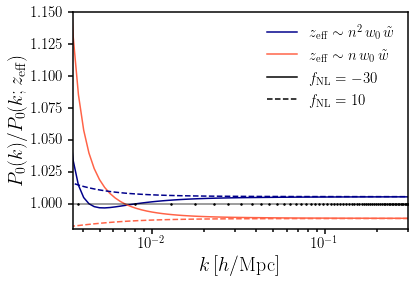

In [32]:
usn2_30 = P0_zeff_fnl(1.76, k, p, fnl_neg, curly_C)
usn210 = P0_zeff_fnl(1.76, k, p, fnl_pos, curly_C)

usn_30 = P0_zeff_fnl(1.81, k, p, fnl_neg, curly_C)
usn10 = P0_zeff_fnl(1.81, k, p, fnl_pos, curly_C)

##fnl=-30
plt.semilogx(k, P0eff_fnl_us_30 / usn2_30, label='$z_{\\rm eff} \sim n^2 \, w_0 \, \\tilde{w}$', color='darkblue')
plt.semilogx(k, P0eff_fnl_us_30 / usn_30, label='$z_{\\rm eff} \sim n \, w_0 \, \\tilde{w}$', color='tomato')

##fnl=10
plt.semilogx(k, P0eff_fnl_us10 / usn210, linestyle='dashed', color='darkblue')
plt.semilogx(k, P0eff_fnl_us10 / usn10, linestyle='dashed', color='tomato')

plt.axhline(1., color='black', alpha=.5)

plt.axhline(2., color='black', label='$f_{\\rm NL} = -30$')
plt.axhline(2., color='black', linestyle="dashed", label='$f_{\\rm NL} = 10$')
#plt.axvline(3.75e-3, linestyle='dotted', color='black', alpha=.3)
plt.semilogx(k_pk, y,'.k', markersize=3)

plt.xlim(3.5e-3,3e-1)
plt.ylim(.98,1.15)

plt.xlabel("$k \, [h/{\\rm Mpc}]$")
plt.ylabel("$P_0(k) / P_0(k;z_{\\rm eff})$")

plt.legend(frameon=False)

plt.savefig("figures/P0eff-ratio-paper.pdf", bbox_inches='tight')

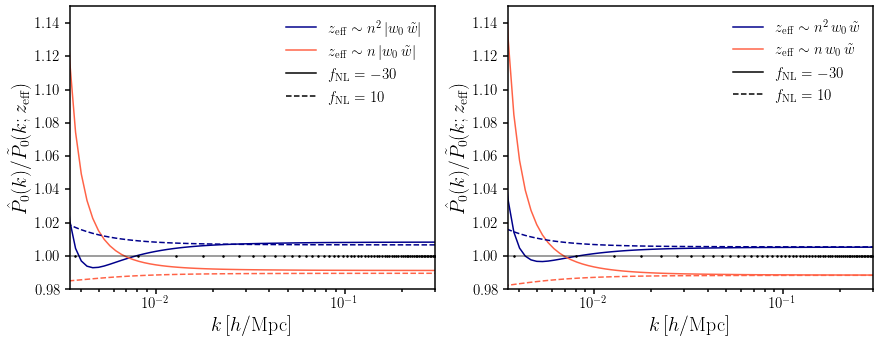

In [70]:
fig, ax = plt.subplots(1,2, figsize=(7.2*2, 5.2))

##fnl=-30
ax[0].semilogx(k, P0eff_fnl_eva_30 / evan2_30, label='$z_{\\rm eff} \sim n^2 \, |w_0 \, \\tilde{w}|$', color='darkblue')
ax[0].semilogx(k, P0eff_fnl_eva_30 / evan_30, label='$z_{\\rm eff} \sim n \, |w_0 \, \\tilde{w}|$', color='tomato')

##fnl=10
ax[0].semilogx(k, P0eff_fnl_eva10 / evan210, linestyle='dashed', color='darkblue')
ax[0].semilogx(k, P0eff_fnl_eva10 / evan10, linestyle='dashed', color='tomato')

ax[0].axhline(1., color='black', alpha=.5)

ax[0].axhline(2., color='black', label='$f_{\\rm NL} = -30$')
ax[0].axhline(2., color='black', linestyle="dashed", label='$f_{\\rm NL} = 10$')
#ax[0].axvline(3.75e-3, linestyle='dotted', color='black', alpha=.3)
ax[0].semilogx(k_pk, y,'.k', markersize=3)

ax[0].set_xlim(3.5e-3,3e-1)
ax[0].set_ylim(.98,1.15)

ax[0].set_xlabel("$k \, [h/{\\rm Mpc}]$")
ax[0].set_ylabel("$\\hat{P}_0(k) / \\tilde{P}_0(k;z_{\\rm eff})$")

ax[0].legend(frameon=False)

#############
##fnl=-30
ax[1].semilogx(k, P0eff_fnl_us_30 / usn2_30, label='$z_{\\rm eff} \sim n^2 \, w_0 \, \\tilde{w}$', color='darkblue')
ax[1].semilogx(k, P0eff_fnl_us_30 / usn_30, label='$z_{\\rm eff} \sim n \, w_0 \, \\tilde{w}$', color='tomato')

##fnl=10
ax[1].semilogx(k, P0eff_fnl_us10 / usn210, linestyle='dashed', color='darkblue')
ax[1].semilogx(k, P0eff_fnl_us10 / usn10, linestyle='dashed', color='tomato')

ax[1].axhline(1., color='black', alpha=.5)

ax[1].axhline(2., color='black', label='$f_{\\rm NL} = -30$')
ax[1].axhline(2., color='black', linestyle="dashed", label='$f_{\\rm NL} = 10$')
#plt.axvline(3.75e-3, linestyle='dotted', color='black', alpha=.3)
ax[1].semilogx(k_pk, y,'.k', markersize=3)

ax[1].set_xlim(3.5e-3,3e-1)
ax[1].set_ylim(.98,1.15)

ax[1].set_xlabel("$k \, [h/{\\rm Mpc}]$")
ax[1].set_ylabel("$\\hat{P}_0(k) / \\tilde{P}_0(k;z_{\\rm eff})$")

ax[1].legend(frameon=False)

#plt.savefig("figures/P0eff-ratio.pdf", bbox_inches='tight')